# Template to explore the effect of shifting baseline


### To check the quality of downscaled model data from ESPO-G6-E5L v1.0.0, we'll be using ERA5 reanalysis data for comparison. 
<br>ERA5 (Reanalyzed data): Combine model data with observation for assimilation. Thus creating improved version of orignial observations.
<br>For more information: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview
<br><br>ESPO-G6-E5L v1.0.0 (Model data): An ensemble of bias-adjusted CMIP6 climate simulations on North America. 
<Br>For more information: https://github.com/Ouranosinc/ESPO-G

Source: 
<br>
Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47 (Accessed on 21-May-2024)
<br><br>Lavoie, J., Bourgault, P., Logan, T., Caron, L.-P., Gammon, S., Smith, T. J., Biner, S., & Leduc, M. (2023). ESPO-G6-E5L : Ensemble de Simulations Post-traitées d'Ouranos - modèles Globaux CMIP6 - ERA5-Land / Ouranos Ensemble of Bias-adjusted Simulations - Global Models CMIP6 - ERA5-Land (ESPO-G6-E5Lv1.0.0). Zenodo. https://doi.org/10.5281/zenodo.7764929
<br><br>For this template, we're going to use Greater Toronto Area (GTA) as example.

### Load packages

In [27]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as st
from pathlib import Path
import cftime as cf
import matplotlib as mpl
import seaborn as sns
mpl.rc('font',size=14)

## Read in model and renalysis data

We are going to create dictionaries (like folders) to store the netCDF files.

In [28]:
# Remember to change the directories below to read in the files
# Let's read inidivdual model data by scenarios
raw_data_245={file.stem :xr.open_dataset(file,drop_variables=['pr','tasmax','tasmin']) for file in Path('data_raw/model_data/GTA/ssp245/').glob('*.nc')}
raw_data_370={file.stem :xr.open_dataset(file,drop_variables=['pr','tasmax','tasmin']) for file in Path('data_raw/model_data/GTA/ssp370/').glob('*.nc')}

# Let's also create ensemble data for later
# We'll create a new dimension called model
raw_ensemble_ssp245=xr.open_mfdataset('data_raw/model_data/GTA/ssp245/*.nc',drop_variables=['pr','tasmax','tasmin'],combine='nested',concat_dim='model',chunks={"time":-1,'model':-1})
raw_ensemble_ssp370=xr.open_mfdataset('data_raw/model_data/GTA/ssp370/*.nc',drop_variables=['pr','tasmax','tasmin'],combine='nested',concat_dim='model',chunks={"time":-1,'model':-1})
# ERA5 data
raw_era_data=xr.open_mfdataset('data_raw/model_data/GTA/era5_gta/era5_single_level/*.nc',chunks={"time":-1}).compute()

### Before carrying out any analysis, let's look at the datasets.

In [29]:
# Model data
raw_data_245['AS-RCEC_TaiESM1_ssp245']

<xarray.Dataset> Size: 62MB
Dimensions:  (lat: 15, lon: 19, time: 54360)
Coordinates:
  * lat      (lat) float32 60B 43.2 43.3 43.4 43.5 43.6 ... 44.3 44.4 44.5 44.6
  * lon      (lon) float32 76B -80.2 -80.1 -80.0 -79.9 ... -78.6 -78.5 -78.4
  * time     (time) object 435kB 1950-01-01 00:00:00 ... 2100-12-30 00:00:00
Data variables:
    tasmean  (time, lat, lon) float32 62MB ...
Attributes: (12/88)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   Hybrid-restart from year 0671-01-01 of p...
    branch_time:                     0.0
    branch_time_in_child:            0.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              AS-RCEC

In [30]:
# Ensemble data
raw_ensemble_ssp245

<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 15, lon: 19, time: 54360, model: 23)
Coordinates:
  * lat      (lat) float32 60B 43.2 43.3 43.4 43.5 43.6 ... 44.3 44.4 44.5 44.6
  * lon      (lon) float32 76B -80.2 -80.1 -80.0 -79.9 ... -78.6 -78.5 -78.4
  * time     (time) object 435kB 1950-01-01 00:00:00 ... 2100-12-30 00:00:00
Dimensions without coordinates: model
Data variables:
    tasmean  (model, time, lat, lon) float32 1GB dask.array<chunksize=(1, 54360, 15, 19), meta=np.ndarray>
Attributes: (12/88)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   Hybrid-restart from year 0671-01-01 of p...
    branch_time:                     0.0
    branch_time_in_child:            0.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              AS-RCEC

In [31]:
# ERA5 data
raw_era_data

<xarray.Dataset> Size: 162MB
Dimensions:    (longitude: 9, latitude: 7, time: 622392)
Coordinates:
  * longitude  (longitude) float32 36B -80.2 -79.95 -79.7 ... -78.7 -78.45 -78.2
  * latitude   (latitude) float32 28B 44.7 44.45 44.2 43.95 43.7 43.45 43.2
  * time       (time) datetime64[ns] 5MB 1950-01-01 ... 2020-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 157MB 275.9 274.5 ... 274.3
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-18 00:40:59 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [32]:
# We can also check the shape of one variable
raw_data_245['AS-RCEC_TaiESM1_ssp245']['tasmean'].shape,raw_era_data['t2m'].shape

((54360, 15, 19), (622392, 7, 9))

## Data Transformation

Here are some key information about model data and ERA5 data. 
<br><br>Model data:
<br>Grid: 15 (lat) X 19 (lon), 0.1° X 0.1° 
<br>Temporal frequency: Daily from 1950 - 2100
<br>Date format: cftime.Datetime360Day (360 days per year)
<br>unit: degree Celsius(&#x2103;)

ERA5 data:
<br>Grid: 7 (lat) X 9 (lon), 0.25° X 0.25°
<br>Temporal frequency: Hourly from 1950 - 2020
<br>Date format: datetime64[ns]* )<br>unit: Kelvin(K)
<br><br>Note that the model and ERA data are different, so we have to transform the data before we can do any analysis. 



In [33]:
# First, we have to convert the datetime format of the dataset
# Then we have to convert hourly data to daily data by taking the mean

era_data_modified=raw_era_data.convert_calendar('360_day',align_on='date')
era_data_modified=era_data_modified.resample(time='1D').mean('time')
# We should also convert Kelvin to degree Celsius(°C)
era_data_modified['t2m']=era_data_modified['t2m']-273.15
# Finally we will have to regrid to match the model data
era_data_modified=era_data_modified.interp(latitude=raw_ensemble_ssp245.lat,longitude=raw_ensemble_ssp245.lon)

#### Now check the modified ERA5 data

In [34]:
era_data_modified

<xarray.Dataset> Size: 29MB
Dimensions:    (time: 25560, lat: 15, lon: 19)
Coordinates:
  * time       (time) object 204kB 1950-01-01 00:00:00 ... 2020-12-30 00:00:00
    latitude   (lat) float32 60B 43.2 43.3 43.4 43.5 ... 44.3 44.4 44.5 44.6
    longitude  (lon) float32 76B -80.2 -80.1 -80.0 -79.9 ... -78.6 -78.5 -78.4
  * lat        (lat) float32 60B 43.2 43.3 43.4 43.5 ... 44.3 44.4 44.5 44.6
  * lon        (lon) float32 76B -80.2 -80.1 -80.0 -79.9 ... -78.6 -78.5 -78.4
Data variables:
    t2m        (time, lat, lon) float32 29MB 3.268 3.254 3.239 ... -4.751 -4.754
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-18 00:40:59 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

### Now that the grid size, unit and temporal format are the same. We can move on for analysis.

## Comparing downscaled model data to ERA5 data

# Clipping

### Let's look how the actual grids look like and compare to the actual map of GTA
<br>Source: Land Information Ontario. Topographic Map Maker [digital resource: raster]. Greater Toronto Area (GTA) 2013 Orthophotography
. Retrieved 05-27-2024, from https://www.arcgis.com/home/item.html?id=9ed81541fead4f5ba9b497d92df42f41.

In [35]:
# read the shapefile and the package with read the rest of the file
# Remember to change the directory below to read in the files
gta_map=[gpd.read_file(file) for file in Path('data_raw/model_data/GTA/map/').glob('*.shp')]

<Axes: title={'center': 'time = 1950-01-01 00:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

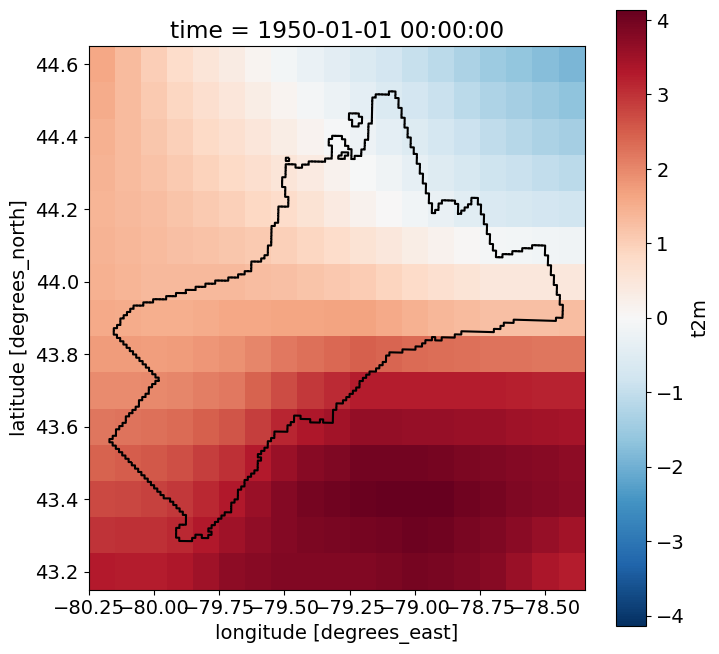

In [36]:
fig,ax=plt.subplots(figsize=(8,8))
era_data_modified.t2m.isel(time=0).plot(ax=ax)
# let's plot
gta_map[0].dissolve().boundary.plot(ax=ax,color='k')

### Since the grid of the model and ERA5 data cover an area greater than GTA, we would have to clip the data for accuracy.

In [37]:
def clipping(dataset,city):
    shp=[gpd.read_file(file) for file in Path('data_raw/model_data/'+city+'/map/').glob('*.shp')]
    data_clipped=dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
    data_clipped=data_clipped.rio.write_crs("epsg:4326")
    data_clipped=data_clipped.rio.clip(shp[0].geometry.values,shp[0].crs, drop = False, invert = False)
    return data_clipped


In [38]:
ensemble_245_clipped=clipping(raw_ensemble_ssp245,'GTA')
ensemble_370_clipped=clipping(raw_ensemble_ssp370,'GTA')
era_clipped=clipping(era_data_modified,'GTA')

### Now let's check the clipped dataset.

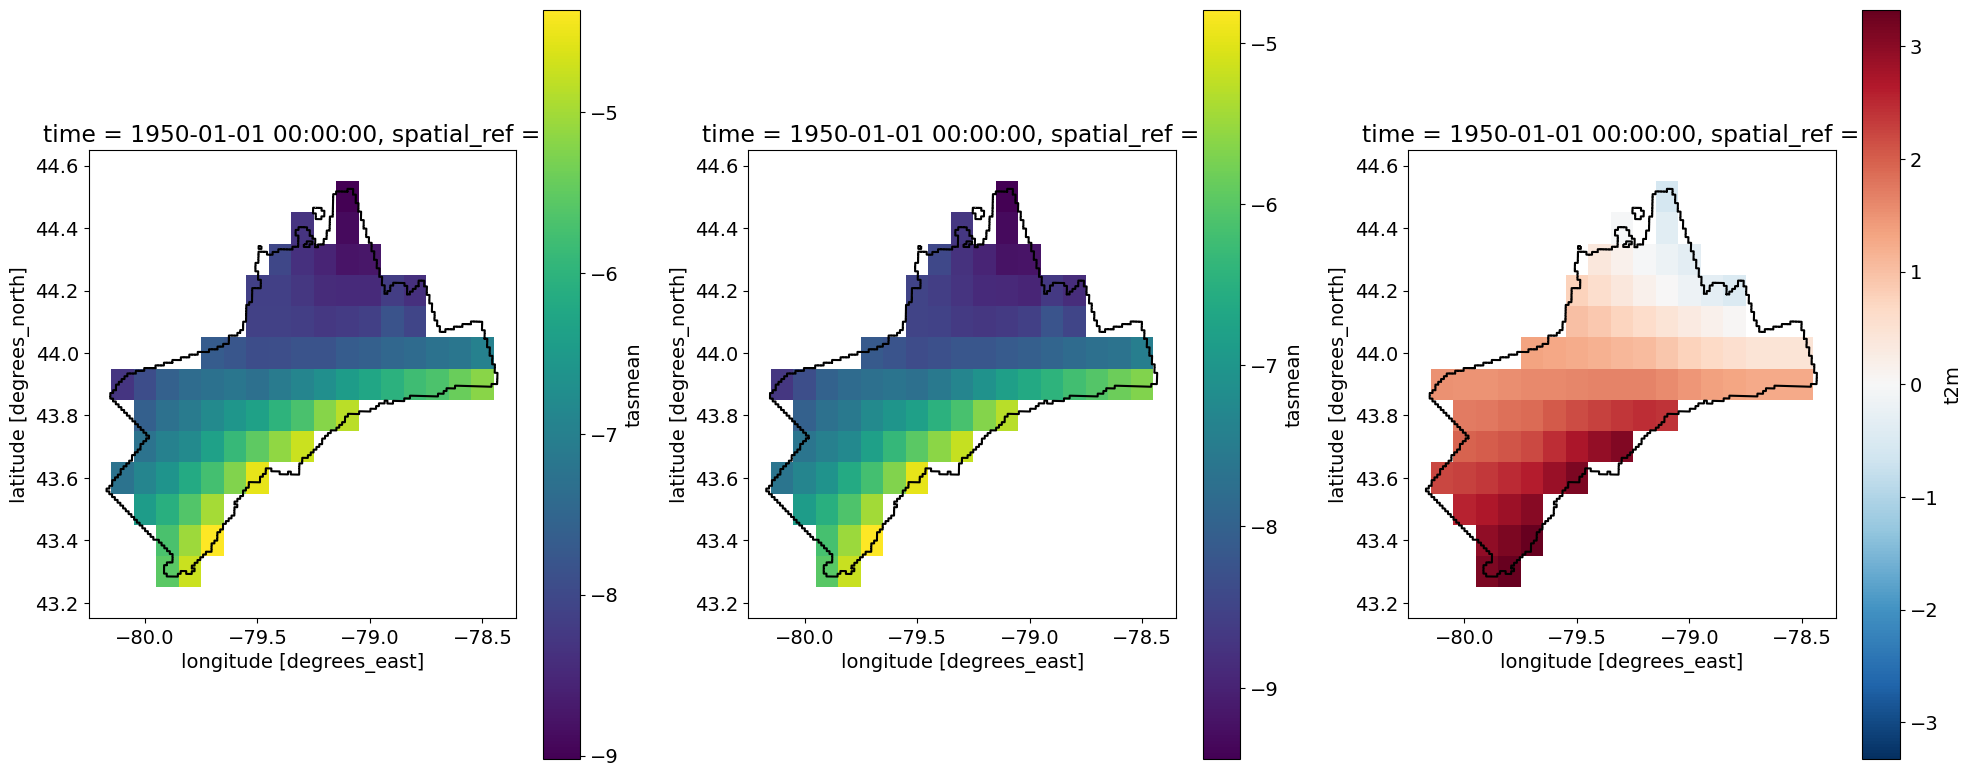

In [39]:
fig,ax=plt.subplots(1,3,figsize=(20,8))
clipped_map=[ensemble_245_clipped.tasmean.mean(dim='model'),ensemble_370_clipped.tasmean.mean(dim='model'),era_clipped.t2m]
for map in enumerate(clipped_map):
    gta_map[0].dissolve().boundary.plot(ax=ax[map[0]],color='k')
    map[1].isel(time=0).plot(ax=ax[map[0]])
fig.tight_layout()

## Mean-bias

## Monthly Means

### Before calcualting the mean-bias, we can look at the monthly mean.

<br>Source: Anderson , C. I., & Smith, K. L. (2023). 12.2 Comparing downscaled data to our observed data | Climate Change Impact Assessment: A practical walk-through. In claut.gitlab.io. https://claut.gitlab.io/man_ccia/lab5.html#comparing-downscaled-data-to-our-observed-data

In [40]:
# Defining the baseline
model_baseline=ensemble_245_clipped.sel(time=slice('1951-01-01','1980-12-30'))
era_baseline=era_clipped.sel(time=slice('1951-01-01','1980-12-30'))
# Group daily data by months and all grids
model_baseline_monthly_mean=model_baseline.groupby('time.month').mean(['time','lat','lon','model'])
era_baseline_monthly_mean=era_baseline.sel(time=slice('1951-01-01','1980-12-30')).groupby('time.month').mean(['time','lat','lon']).compute()
# Calculate the the values of errorbar (1 std)
model_baseline_monthly_std=model_baseline.groupby('time.month').std(['time','lat','lon','model'])
era_baseline_monthly_std=era_clipped.sel(time=slice('1951-01-01','1980-12-30')).groupby('time.month').std(['time','lat','lon']).compute()


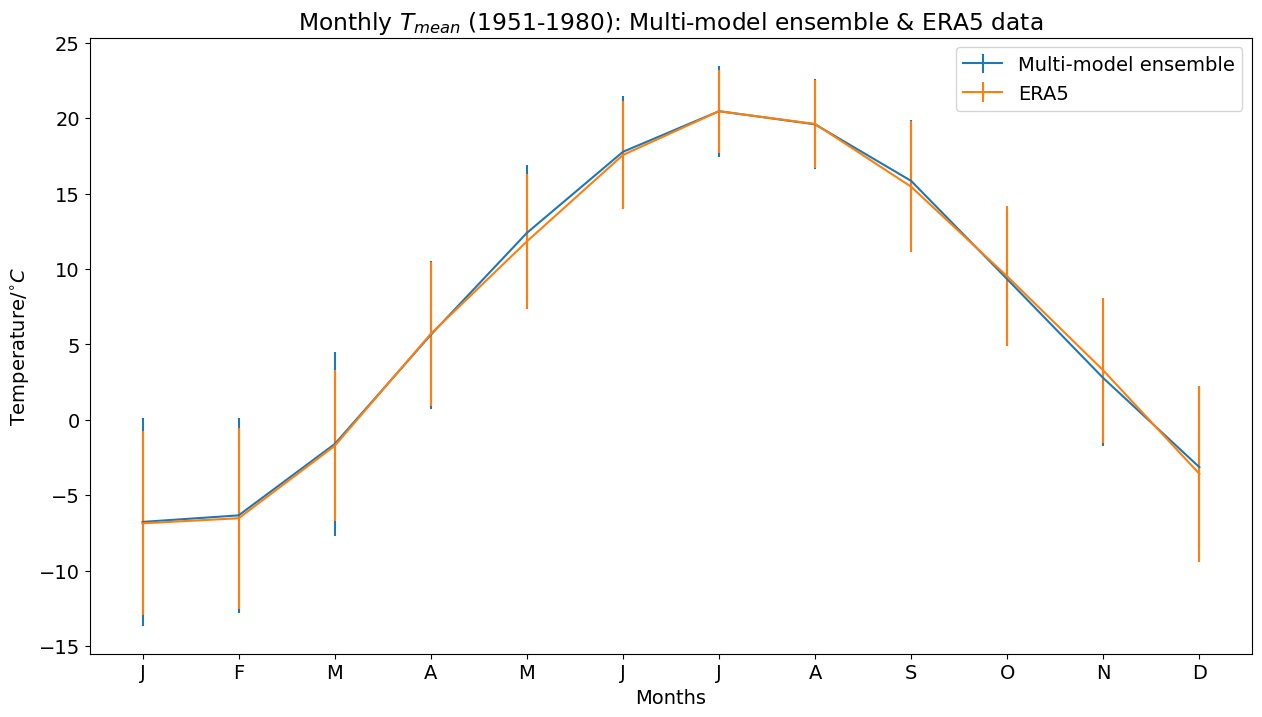

In [41]:
# Let's plot and check the monthly mean
fig,ax=plt.subplots(figsize=(15,8))
# Plot line graph with errorbar
# Model data
ax.errorbar(x=model_baseline_monthly_mean.month,
            y=model_baseline_monthly_mean.tasmean,
            yerr=model_baseline_monthly_std.tasmean,
           label='Multi-model ensemble')

# ERA5 data
ax.errorbar(x=era_baseline_monthly_mean.month,
            y=era_baseline_monthly_mean.t2m,
            yerr=era_baseline_monthly_std.t2m,
           label='ERA5')
# Labelling
ax.set_title('Monthly $T_{mean}$ (1951-1980): Multi-model ensemble & ERA5 data')
ax.set_ylabel('Temperature/$^{\circ}C$')
ax.set_xlabel('Months')
ax.set_xticks(era_baseline_monthly_mean.month,["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.legend()

### Mean-bias

The mean-bias is the difference of mean between model baseline and ERA5 baseline. We will also use T distribution to detect months where there is a **significant difference**.
<br><br>T-test Formula:
<br>$$ T=\frac{m-\mu}{s/\sqrt{N-1}}$$
<br>where m = Model mean
<br>$\mu$ = ERA5 mean
<br>N = Number of models
<br>s = ERA5 standard deviation
<br><br>Source: Anderson , C. I., & Smith, K. L. (2023). Section 12.3 Calculating GCM bias | Climate Change Impact Assessment: A practical walk-through. In claut.gitlab.io. https://claut.gitlab.io/man_ccia/lab5.html#calculating-gcm-bias

In [42]:
# Calculate the mean
monthly_mean_bias=model_baseline_monthly_mean.tasmean.to_numpy()-era_baseline_monthly_mean.t2m.to_numpy()

# calculate the t critical value
# There are 23 models in SSP2-4.5
N=23
t_crit=st.t.ppf(0.975,N-1)
# t sample
t_sample=np.asarray(monthly_mean_bias)*np.sqrt(N-1)/era_baseline_monthly_mean.t2m.to_numpy()
# Month with significant difference
monthly_mean_bias_sig=np.ma.masked_where(np.abs(t_sample) < t_crit, monthly_mean_bias)

In [43]:
# Calculate the full range of bias (max and min - mean)
# Max bias
monthly_mean_bias_max=model_baseline.groupby('time.month').max(
    ['time','lat','lon','model']).tasmean.to_numpy()-era_baseline_monthly_mean.t2m.to_numpy()

# Min bias
monthly_mean_bias_min=model_baseline.groupby('time.month').min(
    ['time','lat','lon','model']).tasmean.to_numpy()-era_baseline_monthly_mean.t2m.to_numpy()

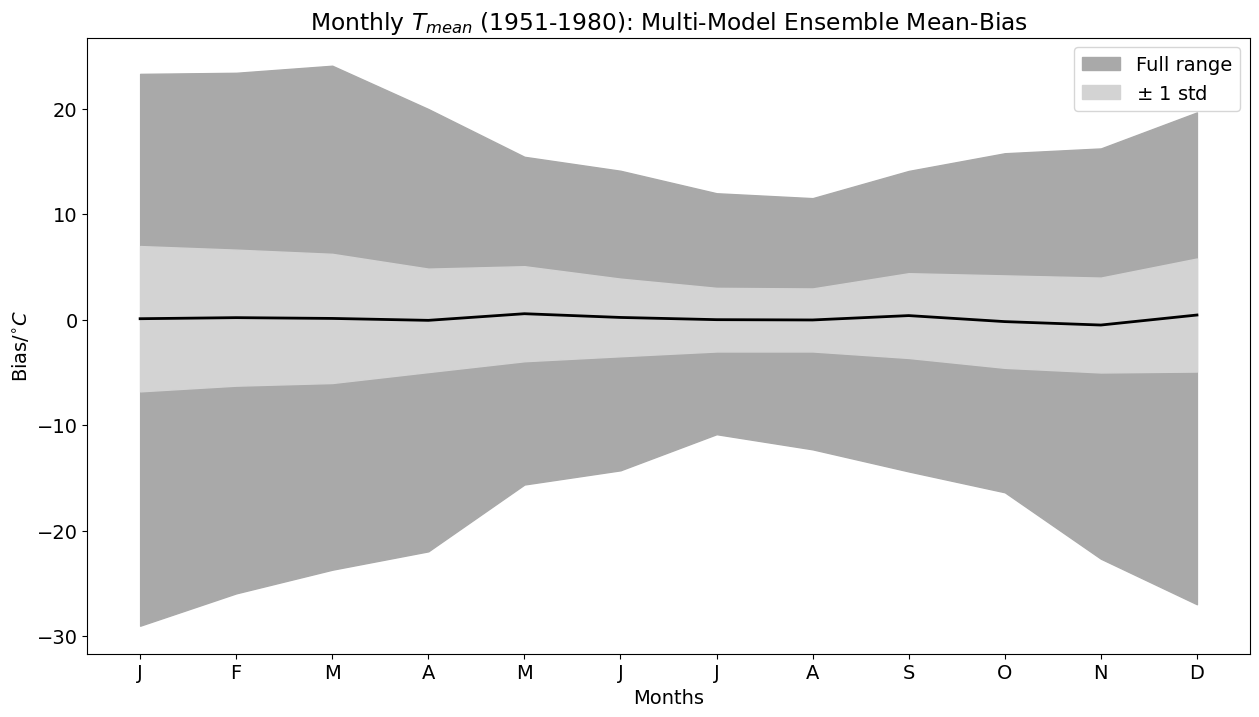

In [44]:
# Let's plot and check the mean-bias
fig,ax=plt.subplots(figsize=(15,8))
# Plot line graph
# Full range of bias
ax.fill_between(model_baseline_monthly_mean.month,
                monthly_mean_bias_max,
                 monthly_mean_bias_min,color='darkgray',
                label='Full range')
# 1 standard deviation
ax.fill_between(model_baseline_monthly_mean.month,
                 monthly_mean_bias+model_baseline_monthly_std.tasmean,
                monthly_mean_bias-model_baseline_monthly_std.tasmean,
                color='lightgray',
               label=r'$\pm$ 1 std')
# mean-bias
ax.plot(model_baseline_monthly_mean.month, monthly_mean_bias, 'k', linewidth=2)
ax.plot(model_baseline_monthly_mean.month, monthly_mean_bias_sig, 'r', linewidth=5)

# Label
ax.set_title('Monthly $T_{mean}$ (1951-1980): Multi-Model Ensemble Mean-Bias')
ax.set_ylabel('Bias/$^{\circ}C$')
ax.set_xlabel('Months')
ax.set_xticks(era_baseline_monthly_mean.month,["J","F","M","A","M","J","J","A","S","O","N","D"])
ax.legend()


# Assessing future 

## Tri-decadal Average Temperature

We can plot out the map of GTA for each tri-decadal period (2021 - 2050 , 2051 - 2080, 2081 - 2100)

Text(0.5, 0.95, 'Mean Temperature of Greater Toronto Area per Tri-Decadal Period and Scenario')

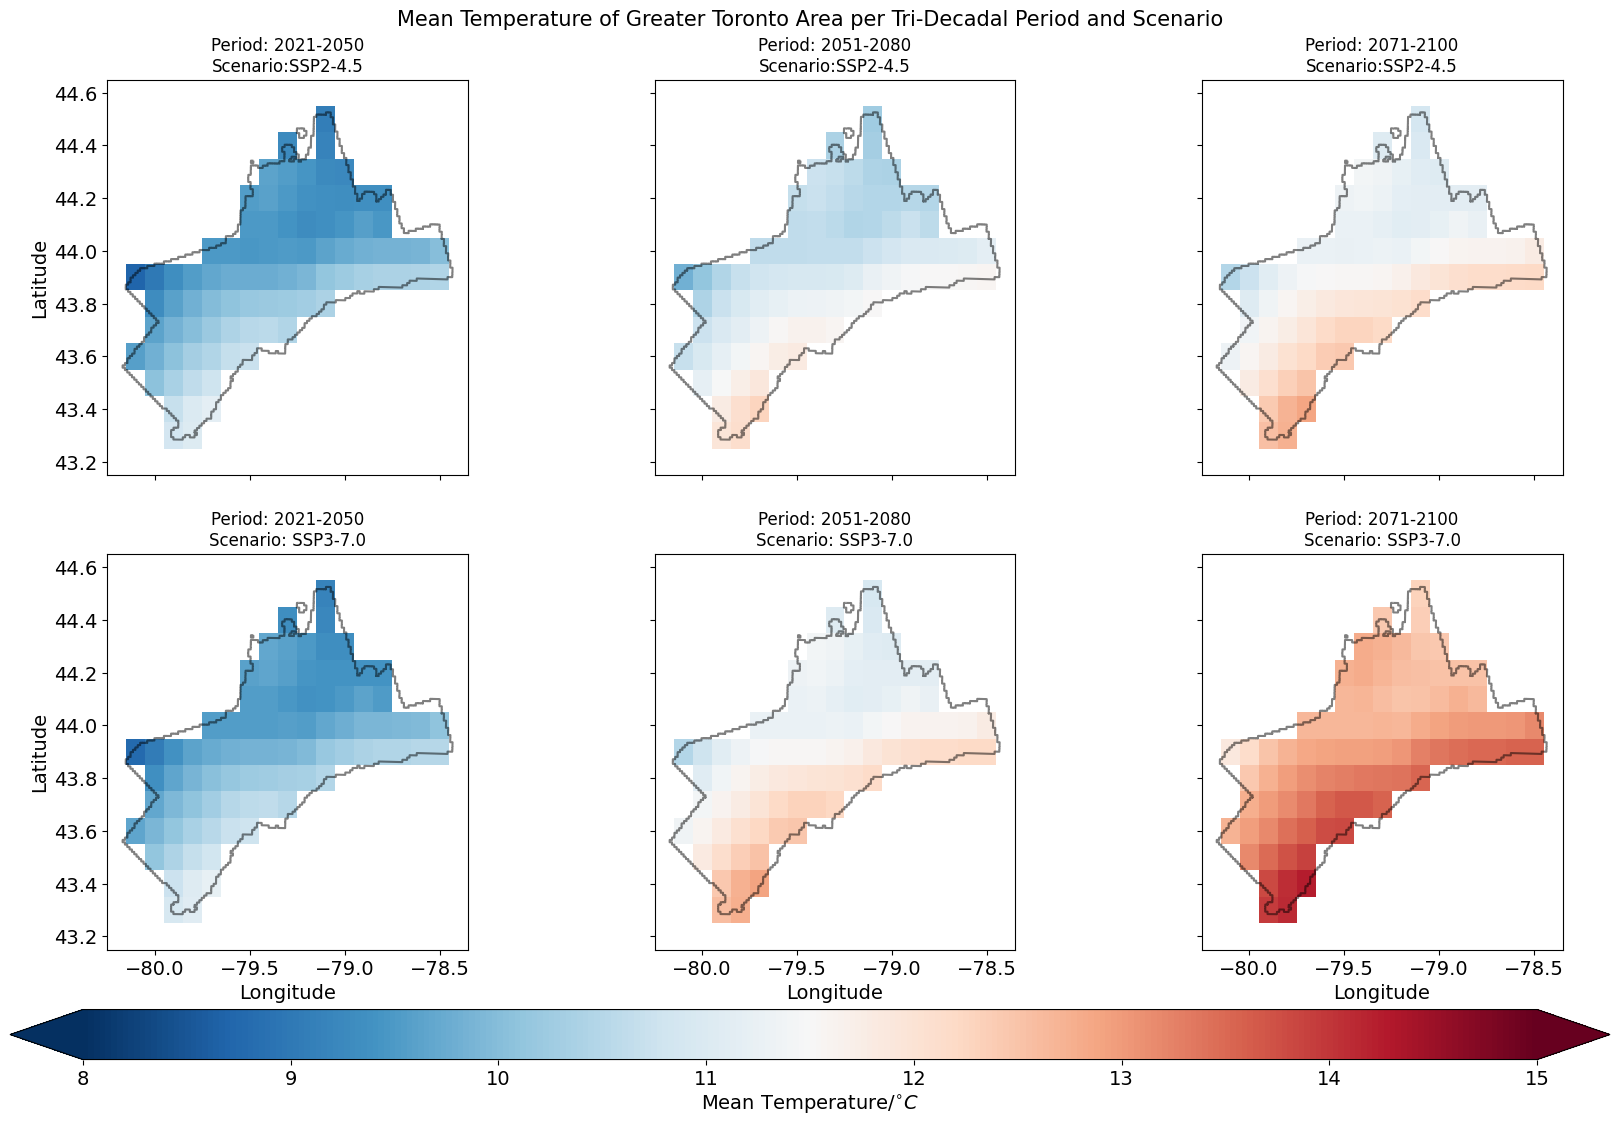

In [45]:
# Define the periods
years=[2021,2051,2071]
# Create a 2 x 3 plot
fig,ax=plt.subplots(2,3,figsize=(20,10),sharey=True,sharex=True)
for year in enumerate(years):
    i=year[0]
    year_start=str(year[1])
    year_end=str(year[1]+29)
    # plot the average mean temperature for each period and scenario
    ensemble_245_clipped.tasmean.sel(time=slice(year_start+'-01-01',
                                                year_end+'-12-30')).mean(['time','model']).compute().plot(ax=ax[0,i],add_colorbar=False,cmap="RdBu_r",vmin=8, vmax=15)
    gta_map[0].dissolve().boundary.plot(ax=ax[0,i],color='k',alpha=0.5)
    axs=ensemble_370_clipped.tasmean.sel(time=slice(year_start+'-01-01',
                                                year_end+'-12-30')).mean(['time','model']).compute().plot(ax=ax[1,i],add_colorbar=False,cmap="RdBu_r",vmin=8, vmax=15)
    gta_map[0].dissolve().boundary.plot(ax=ax[1,i],color='k',alpha=0.5)
    # Label and legends
    ax[0,i].set_title('Period: '+year_start+'-'+year_end+'\nScenario:SSP2-4.5',fontsize=12)
    ax[1,i].set_title('Period: '+year_start+'-'+year_end+'\nScenario: SSP3-7.0',fontsize=12)
    # Remove x and y labels for plots in the middle and right
    ax[0,i].set_xlabel('')
    ax[1,i].set_xlabel('Longitude')
    if i==0:
        ax[0,i].set_ylabel('Latitude')
        ax[1,i].set_ylabel('Latitude')
    else:
        ax[0,i].set_ylabel('')
        ax[1,i].set_ylabel('')

# Create extra axes for color bar
fig.subplots_adjust(bottom=0.01) #also try using kwargs bottom, top, or hspace 
cbar_ax = fig.add_axes([0.1, -0.1, .8, .05]) #left, bottom, width, height
fig.colorbar(axs,cax=cbar_ax,orientation='horizontal',label='Mean Temperature/$^{\circ}C$',extend='both')
fig.suptitle('Mean Temperature of Greater Toronto Area per Tri-Decadal Period and Scenario',y=0.95,fontsize=15)


# Temperature Projection

In [46]:
# Computing the annual average temperature for the entire area
ensemble_annual_ssp245=ensemble_245_clipped.groupby('time.year').mean(['time','lat','lon','model'])
model_annual_ssp245=ensemble_245_clipped.groupby('time.year').mean(['time','lat','lon'])
model_annual_ssp370=ensemble_370_clipped.groupby('time.year').mean(['time','lat','lon'])
ensemble_annual_ssp370=ensemble_370_clipped.groupby('time.year').mean(['time','lat','lon','model'])
# rechunk the data 
model_annual_ssp245_rechunk=model_annual_ssp245.chunk(chunks={'year':-1,'model':-1})
model_annual_ssp370_rechunk=model_annual_ssp370.chunk(chunks={'year':-1,'model':-1})

# Compute the 10th and 90th quantiles
q90_ssp245=model_annual_ssp245_rechunk.quantile(0.9,dim=['model']).compute()
q10_ssp245=model_annual_ssp245_rechunk.quantile(0.1,dim=['model']).compute()

q90_ssp370=model_annual_ssp370_rechunk.quantile(0.9,dim=['model']).compute()
q10_ssp370=model_annual_ssp370_rechunk.quantile(0.1,dim=['model']).compute()

In [53]:
ensemble_annual_ssp245

<xarray.Dataset> Size: 2kB
Dimensions:      (year: 151)
Coordinates:
    spatial_ref  int32 4B 0
  * year         (year) int64 1kB 1950 1951 1952 1953 ... 2097 2098 2099 2100
Data variables:
    tasmean      (year) float32 604B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/88)
    Conventions:                     CF-1.7 CMIP-6.2
    Notes:                           Regridded on the grid of ERA5-Land, then...
    activity_id:                     CMIP
    branch_method:                   Hybrid-restart from year 0671-01-01 of p...
    branch_time:                     0.0
    branch_time_in_child:            0.0
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.24381/cds.e2161bac
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              AS-RCEC

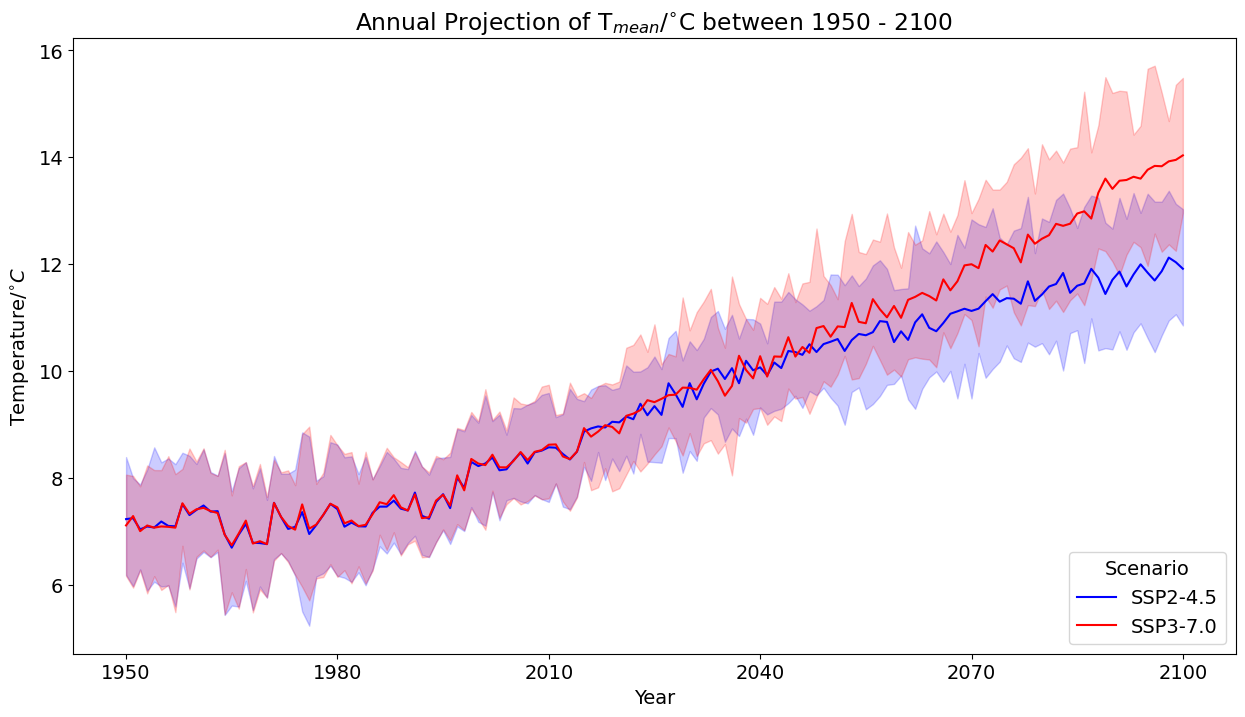

In [47]:
# plot the projection time series
fig,ax=plt.subplots(figsize=(15,8))
# SSP2-4.5
ensemble_annual_ssp245.tasmean.plot(ax=ax,color='b',label='SSP2-4.5')
# SSP3-7.0
ensemble_annual_ssp370.tasmean.plot(ax=ax,color='r',label='SSP3-7.0')
# Shade the region between 10th and 90th 
ax.fill_between(model_annual_ssp245.year,q90_ssp245.tasmean,q10_ssp245.tasmean,alpha=0.2,color='b')
ax.fill_between(model_annual_ssp245.year,q90_ssp370.tasmean,q10_ssp370.tasmean,alpha=0.2,color='r')
# Labels and legends
ax.set_title('Annual Projection of T$_{mean}/^{\circ}$C between 1950 - 2100')
ax.set_ylabel('Temperature/$^{\circ}C$')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(1950,2130,30),np.arange(1950,2130,30))
ax.legend(loc=4,title='Scenario')

# Shifting Baseline

<br><br>The projection of temperature above is computed with a stationary baseline, which means the 30-year reference period remains the same for the entire time series. Now, we will look at the impact of shifting baseline, which means the reference period will be moving along with the projection for every decade.
<br><br>For example:
| Time Period of Interest | 2021 - 2050 | 2051 - 2080 | 2081 - 2100
| --- | --- | --- | --- |
| Stationary Baseline | 1991 - 2020 | 1991 - 2020 | 1991 - 2020 |
| Shifting Baseline | 2011 - 2040 | 2041 - 2070 | 2071 - 2090 |

In [48]:
# let's create a function to compute 
def create_baseline(model,method='shifting'): #The default method for this function would be shifting baseline 
     # for shifting baseline
     if method=='shifting':
          data=model.tasmean.sel(year=slice('1960','2100'))-model.tasmean.sel(year=slice('1950','2090')).to_numpy()
     # for stationary baseline:
     elif method=='stationary':
          # let's create a array with the baseline
          baseline_mean=model.tasmean.sel(year=slice('1991','2020')).mean().values
          series=model.tasmean.sel(year=slice('1960','2100'))
          data=series-baseline_mean
     return data

In [49]:
# Let's compute both time series
shifted_245=create_baseline(model_annual_ssp245)
stat_245=create_baseline(model_annual_ssp245,'stationary')
shifted_370=create_baseline(model_annual_ssp370)
stat_370=create_baseline(model_annual_ssp370,'stationary')


In [50]:
# Again, we have to rechunk the data 
shifted_ssp245_rechunk=shifted_245.chunk(chunks={'year':-1,'model':-1})
stat_ssp245_rechunk=stat_245.chunk(chunks={'year':-1,'model':-1})

shifted_ssp370_rechunk=shifted_370.chunk(chunks={'year':-1,'model':-1})
stat_ssp370_rechunk=stat_370.chunk(chunks={'year':-1,'model':-1})

# Again, compute the 10th and 90th quantiles
shifted_245_90=shifted_ssp245_rechunk.quantile(0.9,dim=['model']).compute()
shifted_245_10=shifted_ssp245_rechunk.quantile(0.1,dim=['model']).compute()

stat_245_90=stat_ssp245_rechunk.quantile(0.9,dim=['model']).compute()
stat_245_10=stat_ssp245_rechunk.quantile(0.1,dim=['model']).compute()

shifted_370_90=shifted_ssp370_rechunk.quantile(0.9,dim=['model']).compute()
shifted_370_10=shifted_ssp370_rechunk.quantile(0.1,dim=['model']).compute()

stat_370_90=stat_ssp370_rechunk.quantile(0.9,dim=['model']).compute()
stat_370_10=stat_ssp370_rechunk.quantile(0.1,dim=['model']).compute()

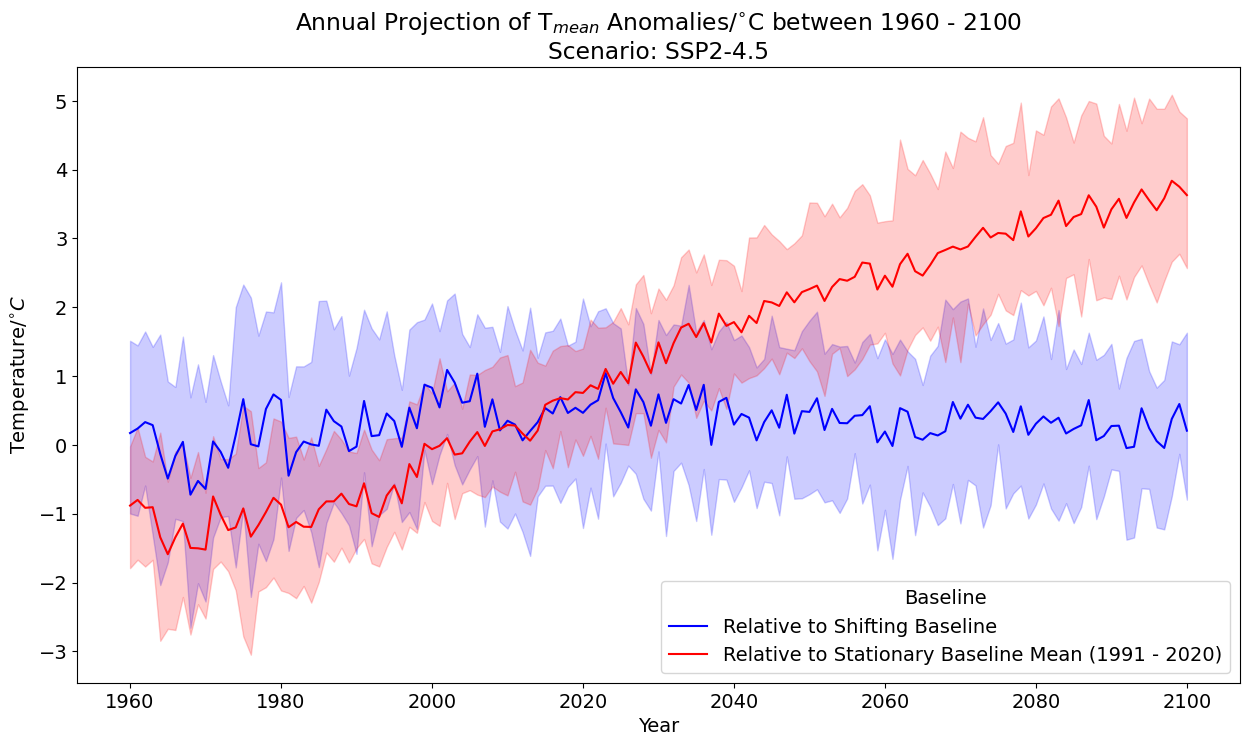

In [51]:
# plot the projection time series
fig,ax=plt.subplots(figsize=(15,8))
# Shifted Baseline
shifted_245.mean(dim='model').plot(ax=ax,color='b',label='Relative to Shifting Baseline')
# Stationary Baseline
stat_245.mean(dim='model').plot(ax=ax,color='r',label='Relative to Stationary Baseline Mean (1991 - 2020)')
# Shade the region between 10th and 90th 
ax.fill_between(shifted_245.year,shifted_245_10,shifted_245_90,alpha=0.2,color='b')
ax.fill_between(shifted_245.year,stat_245_10,stat_245_90,alpha=0.2,color='r')
# Labels and legends
ax.set_title('Annual Projection of T$_{mean}$ Anomalies/$^{\circ}$C between 1960 - 2100\nScenario: SSP2-4.5')
ax.set_ylabel('Temperature/$^{\circ}C$')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(1960,2120,20),np.arange(1960,2120,20))
ax.legend(loc=4,title='Baseline')

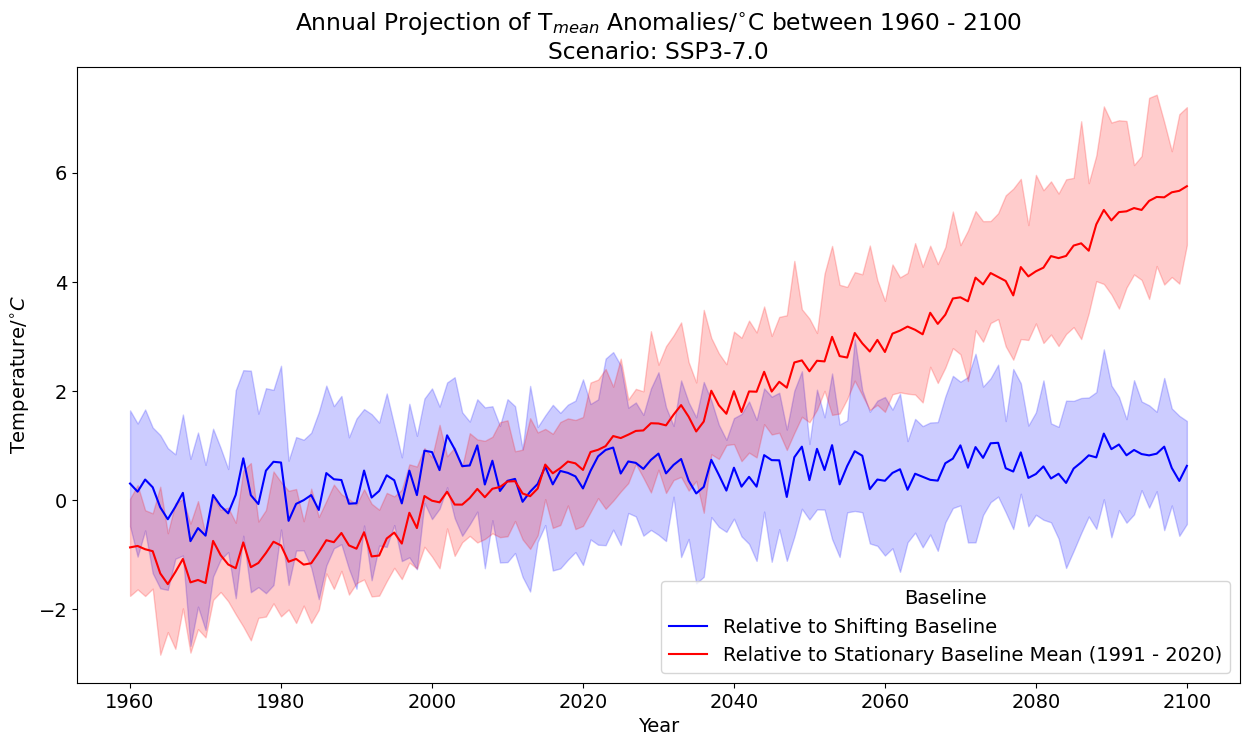

In [52]:
# plot the projection time series
fig,ax=plt.subplots(figsize=(15,8))
# Shifted Baseline
shifted_370.mean(dim='model').plot(ax=ax,color='b',label='Relative to Shifting Baseline')
# Stationary Baseline
stat_370.mean(dim='model').plot(ax=ax,color='r',label='Relative to Stationary Baseline Mean (1991 - 2020)')
# Shade the region between 10th and 90th 
ax.fill_between(shifted_370.year,shifted_370_10,shifted_370_90,alpha=0.2,color='b')
ax.fill_between(shifted_370.year,stat_370_10,stat_370_90,alpha=0.2,color='r')
# Labels and legends
ax.set_title('Annual Projection of T$_{mean}$ Anomalies/$^{\circ}$C between 1960 - 2100\nScenario: SSP3-7.0')
ax.set_ylabel('Temperature/$^{\circ}C$')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(1960,2120,20),np.arange(1960,2120,20))
ax.legend(loc=4,title='Baseline')